In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import matplotlib
matplotlib.rcParams['font.size'] = 18

import keras 
import tensorflow as tf

from keras import models, layers, optimizers, losses, metrics, callbacks

Using TensorFlow backend.


# Data

In [2]:
def format_data():
    train = pd.read_csv('numerai_datasets/numerai_training_data.csv')
    test = pd.read_csv('numerai_datasets/numerai_tournament_data.csv')
    
    features = [f for f in list(train) if "feature" in f]
    X = train[features]
    Y = train.target
    X_test = test[features]
    ids = test['id']
    
    X_valid = test.ix[test['data_type'] == 'validation', features]
    Y_valid = test.ix[test['data_type'] == 'validation', 'target']
    
    return X, Y, X_valid, Y_valid, X_test, ids

In [3]:
X, Y, X_valid, Y_valid, X_test, ids = format_data()

In [6]:
print(X.shape)
print(X_valid.shape)
print(X_test.shape)

(393613, 50)
(46362, 50)
(243393, 50)


In [ ]:
Y.value_counts()

In [ ]:
def model(train, test):
    features = [f for f in list(train) if "feature" in f]
    X = train[features]
    Y = train['target']
    X_prediction = test[features]
    ids = test['id']
    
    pca = PCA(n_components=0.95)
    X = pca.fit_transform(X)
    X_prediction = pca.transform(X_prediction)
    
    model = ExtraTreesClassifier(n_estimators = 100, verbose = 1, n_jobs=-1)
    # model = LogisticRegression(n_jobs=-1)
    model.fit(X, Y)
    
    predictions = model.predict_proba(X_prediction)
    probabilities = predictions[:, 1]
    
    results_df = pd.DataFrame({'probability': probabilities})
    results_df = pd.DataFrame(ids).join(results_df)
    
    return results_df

In [ ]:
results = model(train, test)
results.to_csv('numerai_extratrees.csv', index=False)

# Keras Neural Network

In [10]:
def plot_history(history):
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    epochs = [int(i) for i in list(range(1, len(val_loss) + 1))]
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(epochs, train_loss, 'bo-', label = 'training loss')
    plt.plot(epochs, val_loss, 'ro-', label = 'validation loss')
    plt.xlabel('Epoch'); plt.ylabel('Log Loss'); plt.title('Training Curves')
    plt.legend();
    plt.show()
    

In [11]:
pca = PCA(n_components = 0.99)
scaler = MinMaxScaler()

X = pca.fit_transform(X)
X_valid = pca.transform(X_valid)
X_test = pca.transform(X_test)

X = scaler.fit_transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [12]:
X.shape

(393613, 35)

In [24]:
model = models.Sequential()
model.add(layers.Dense(128, activation = 'elu', input_dim = X.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'elu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, activation = 'elu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation = 'elu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation = 'elu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(32, activation = 'elu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = losses.binary_crossentropy,
              metrics = [losses.binary_crossentropy],
              optimizer = optimizers.Adam())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               4608      
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               262400    
__________

Train on 393613 samples, validate on 46362 samples
Epoch 1/25
393613/393613 [==============================] - 16s 42us/step - loss: 0.6965 - binary_crossentropy: 0.6965 - val_loss: 0.6928 - val_binary_crossentropy: 0.6928
Epoch 2/25
393613/393613 [==============================] - 14s 36us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/25
393613/393613 [==============================] - 14s 36us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 4/25
393613/393613 [==============================] - 15s 38us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929


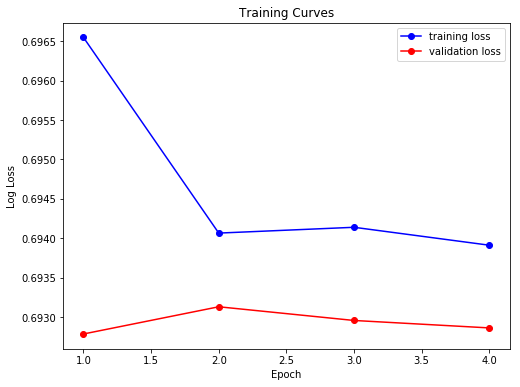

In [25]:
callback_list = [callbacks.ModelCheckpoint(filepath='models/numerai_nn_1.hdf5', save_best_only = True, monitor = 'val_loss'),
                callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)]

history = model.fit(X, Y, epochs = 25, batch_size = 2048, 
                    validation_data = [X_valid, Y_valid], callbacks=callback_list)    

plot_history(history)

In [26]:
model.load_weights('models/numerai_nn_1.hdf5')
p_array = model.predict(X_test)
p = p_array[:, 0]

In [27]:
results = pd.DataFrame({'id': ids, 'probability': p})
results.to_csv('numerai_nn.csv', index=False)

# Traditional Methods

In [ ]:
corrs = pd.Series(train.corr()['target'].sort_values())

In [ ]:
top_corrs = corrs[abs(corrs.values) > 0.01]
top_corrs_names = list(top_corrs.index)
top_corrs_names.remove('target')

In [ ]:
# features = [f for f in list(train) if "feature" in f]
features = top_corrs_names
X = train[features]
Y = train['target']
X_test = test[features]

X_valid = test.ix[test['data_type'] == 'validation', features]
Y_valid = test.ix[test['data_type'] == 'validation', 'target']
ids = test['id']

# Logistic Regression

In [ ]:
lr_model = LogisticRegressionCV(n_jobs=-1, cv = 3, Cs=50, scoring = 'log_loss')
lr_model.fit(X, Y)

In [ ]:
lr_valid_pred = lr_model.predict_proba(X_valid)[:, 1]
print('Validation Log Loss using Logistic Regression = {:0.6f}.'.format(log_loss(Y_valid, lr_valid_pred)))

In [ ]:
lr_pred = lr_model.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'id': ids, 'probability': lr_pred})
results.to_csv('submissions/101/lr_cv.csv', index=False)

In [ ]:
gnb = GaussianNB()
gnb.fit(X, Y)

In [ ]:
gnb_valid_pred = gnb.predict_proba(X_valid)[:, 1]
print('Validation Log Loss using Logistic Regression = {:0.6f}.'.format(log_loss(Y_valid, gnb_valid_pred)))

In [ ]:
gnb_pred = gnb.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'id': ids, 'probability': gnb_pred})
results.to_csv('submissions/101/gnb.csv', index=False)

In [ ]:
combined_valid = 0.8 * lr_valid_pred + 0.2 * gnb_valid_pred
print('Validation Log Loss Combined = {:0.6f}.'.format(log_loss(Y_valid, combined_valid)))

In [ ]:
combined_pred = 0.8 * lr_pred + 0.2 * gnb_pred
results = pd.DataFrame({'id': ids, 'probability': combined_pred})
results.to_csv('submissions/101/lr_gnb.csv', index=False)

In [ ]:
features = [f for f in list(train) if "feature" in f]
# features = top_corrs_names
X = train[features]
Y = train['target']
X_test = test[features]

X_valid = test.ix[test['data_type'] == 'validation', features]
Y_valid = test.ix[test['data_type'] == 'validation', 'target']
ids = test['id']

In [ ]:
lr_model2 = LogisticRegressionCV(n_jobs=-1, cv = 3, Cs=50, scoring = 'log_loss')
lr_model2.fit(X, Y)

In [ ]:
lr_valid_pred2 = lr_model2.predict_proba(X_valid)[:, 1]
print('Validation Log Loss using Logistic Regression = {:0.6f}.'.format(log_loss(Y_valid, lr_valid_pred2)))

In [ ]:
lr_valid_pred = lr_model.predict_proba(X_valid)[:, 1]
print('Validation Log Loss using Logistic Regression = {:0.6f}.'.format(log_loss(Y_valid, lr_valid_pred)))

In [ ]:
log_loss(Y_valid, [0.5 for _ in range(len(Y_valid))])

In [ ]:
-np.log(0.5)

In [ ]:
p = lr_model.predict_proba(X_test)[:, 1]
results = pd.DataFrame({'id': ids, 'probability': p})
results.to_csv('submissions/numerai4.csv', index=False)

# Support Vector Machine

In [4]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [5]:
full_X = train[features]
full_X_test = test[features]
full_X_valid = test.ix[test['data_type'] == 'validation', features]

In [ ]:
svm = SVC(probability=True)
svm.fit(full_X, Y)

In [ ]:
svm_valid_pred = svm.predict_proba(full_X_valid)[:, 1]
print('Validation Log Loss using Support Vector Classifier = {:0.6f}.'.format(log_loss(Y_valid, svm_valid_pred)))